In [1]:
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

import pandas as pd
import psycopg

db = psycopg.connect("dbname=next host=localhost port=5432 user=postgres password=postgres")

factions = pd.read_sql_query("select * from open_discourse.factions", db)
print(factions)

    id  abbreviation                                          full_name
0   -1     not found                                          not found
1    0           AfD                        Alternative für Deutschland
2    1           BHE      Block der Heimatvertriebenen und Entrechteten
3    2            BP                                       Bayernpartei
4    3         Grüne                              Bündnis 90/Die Grünen
5    4       CDU/CSU  Christlich Demokratische Union Deutschlands/Ch...
6    5            DA                  Demokratische Arbeitsgemeinschaft
7    6    DIE LINKE.                                         DIE LINKE.
8    7            DP                                    Deutsche Partei
9    8        DP/DBP             Deutsche Partei/Deutsche Partei Bayern
10   9        DP/FVP                  Deutsche Partei/Freie Volkspartei
11  10           DPB                             Deutsche Partei Bayern
12  11           DRP                              Deutsche Refor

In [61]:
speeches = pd.read_sql_query("select * from open_discourse.speeches limit 10", db)
print(speeches)

   id  session  electoral_term first_name last_name  politician_id  \
0   0        2               1               Köhler       11001150   
1   1        2               1               Arnold             -1   
2   2        2               1               Köhler       11001150   
3   3        2               1                Heuss             -1   
4   4        2               1               Köhler       11001150   
5   5        2               1                Heuss             -1   
6   6        3               1               köhler       11001150   
7   7        3               1             adenauer       11000009   
8   8        3               1               köhler       11001150   
9   9        4               1               köhler       11001150   

                                      speech_content  faction_id  \
0  Meine Damen und Herren! Ich eröffne die 2. Sit...          -1   
1    Der Bundesrat ist versammelt, Herr Präsident.\n          -1   
2  Ich danke für diese Er

In [52]:
speeches = pd.read_sql_query("""
    SELECT speech_content, factions.abbreviation as faction, electoral_term, date_part('year', date)::int as year
    FROM open_discourse.speeches
    JOIN open_discourse.factions ON factions.id = speeches.faction_id
    WHERE faction_id <> -1 AND faction_id <> 16
    AND electoral_term IN (19, 20)
    """, db)
print(speeches.shape)
print(speeches.head())

(40151, 4)
                                      speech_content  faction  electoral_term  \
0  \n\nJa, ich nehme die Wahl mit großer Freude a...    Grüne              19   
1  \n\nSehr geehrter Herr Präsident! Sehr geehrte...      SPD              19   
2  \n\nVielen Dank. – Herr Präsident! Meine sehr ...      SPD              19   
3  \n\nSehr geehrter Herr Präsident! Liebe Kolleg...  CDU/CSU              19   
4  \n\nHerr Präsident! Liebe Kolleginnen und Koll...      SPD              19   

   year  
0  2017  
1  2017  
2  2017  
3  2017  
4  2017  


In [5]:
import numpy as np
from sentence_transformers import SentenceTransformer
import umap

# model = SentenceTransformer("deutsche-telekom/gbert-large-paraphrase-euclidean") # Large model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
print("Model loaded")

Model loaded


In [53]:
# Calculate embeddings for each speech
embeddings = model.encode(speeches["speech_content"].values, convert_to_numpy=True)
print("Encoded!")

Encoded!


In [54]:
speech_indices_by_faction_and_year = speeches.groupby(["faction", "year"]).groups

embedding_averages = {
    faction_and_year: np.mean(embeddings[indices], axis=0)
    for faction_and_year, indices in speech_indices_by_faction_and_year.items()
}
print(embedding_averages.keys())

reduced_embeddings = umap.UMAP().fit_transform(list(embedding_averages.values()))
print(reduced_embeddings)

dict_keys([('AfD', 2017), ('AfD', 2018), ('AfD', 2019), ('AfD', 2020), ('AfD', 2021), ('AfD', 2022), ('CDU/CSU', 2017), ('CDU/CSU', 2018), ('CDU/CSU', 2019), ('CDU/CSU', 2020), ('CDU/CSU', 2021), ('CDU/CSU', 2022), ('DIE LINKE.', 2017), ('DIE LINKE.', 2018), ('DIE LINKE.', 2019), ('DIE LINKE.', 2020), ('DIE LINKE.', 2021), ('DIE LINKE.', 2022), ('FDP', 2017), ('FDP', 2018), ('FDP', 2019), ('FDP', 2020), ('FDP', 2021), ('FDP', 2022), ('Grüne', 2017), ('Grüne', 2018), ('Grüne', 2019), ('Grüne', 2020), ('Grüne', 2021), ('Grüne', 2022), ('SPD', 2017), ('SPD', 2018), ('SPD', 2019), ('SPD', 2020), ('SPD', 2021), ('SPD', 2022)])
[[ 11.062194  -15.006811 ]
 [ 10.804404  -14.871762 ]
 [ 10.462493  -14.837365 ]
 [ 10.387644  -15.322197 ]
 [  9.931069  -15.431571 ]
 [ 10.564125  -15.4827   ]
 [  6.7959123 -14.215238 ]
 [  6.282268  -14.722824 ]
 [  6.4964056 -14.928029 ]
 [  6.5311117 -15.638673 ]
 [  6.8476257 -16.01333  ]
 [  7.562666  -16.60849  ]
 [  7.8644567 -13.887624 ]
 [ 10.9688015 -15.8

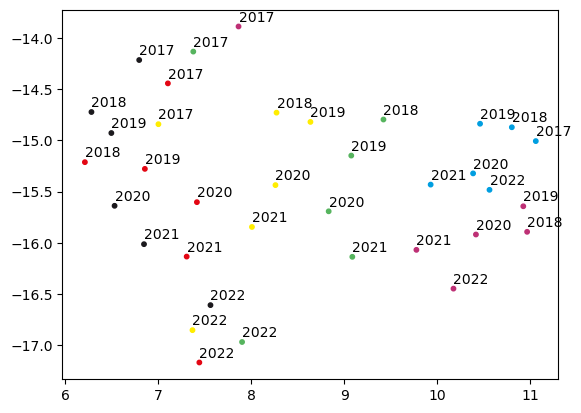

In [66]:
import matplotlib.pyplot as plt

colours = {
    "AfD": "#009ee0",
    "CDU/CSU": "#1b191d",
    "DIE LINKE.": "#be3075",
    "FDP": "#ffed00",
    "Grüne": "#56b45e",
    "SPD": "#e30613"
}
keys = list(embedding_averages.keys())

scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=[colours[key[0]] for key in keys], s=10)

for i, embedding in enumerate(reduced_embeddings):
    plt.annotate(keys[i][1], (embedding[0], embedding[1] + 0.05))
#plt.legend(*scatter.legend_elements())
plt.show()

#import umap.plot

#faction_labels = pd.DataFrame({"factions": [f'{key[0]} {key[1]}' for key in embedding_averages.keys()]})["factions"]
#umap.plot.points(reducer, labels=faction_labels)